# Moneyball in the IPL: Quantifying Value Beyond the Price Tag

## 1. The Hook: The "Winner's Curse"

The IPL 2025 auction has concluded, leaving us with staggering numbers. Teams have spent over **₹600 Crores** on just a handful of marquee players. But in a salary-capped league, every rupee spent on one player is a rupee *not* spent on another.

This brings us to the core economic question of the IPL:

> **"Is a 27 Crore player actually providing 27 times the value of a 1 Crore player? If not, what is the 'Fair Value'?"**

In this analysis, we move beyond simple batting averages and strike rates to quantify the *true economic efficiency* of IPL teams. We introduce a new metric, **VOMAM (Value Over Market Adjusted Model)**, to identify the real winners and losers of the auction.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Constants
TEAM_PURSE_2025 = 120.0  # Crores
PROJECT_ROOT = Path('..')

# Load Data
def load_data():
    # Load mapped data
    war_price_file = PROJECT_ROOT / 'results' / '11_war_vs_price' / 'war_vs_price_full.csv'
    df = pd.read_csv(war_price_file)
    
    # Filter mapped players
    df = df[df['match_type'] != 'none'].copy()
    
    # Load metadata
    meta_file = PROJECT_ROOT / 'data' / 'player_metadata.csv'
    metadata = pd.read_csv(meta_file)
    
    # Merge
    df = df.merge(metadata[['player_name', 'country', 'role_category']], 
                  left_on='cricwar_name', right_on='player_name', how='left')
    
    # Feature Engineering
    df['price_norm'] = (df['price_cr'] / TEAM_PURSE_2025) * 100
    df['is_overseas'] = df['country'].apply(lambda x: 0 if str(x).lower() in ['india', 'ind'] else 1)
    df['role_category'] = df['role_category'].fillna('Unknown')
    
    return df

df = load_data()
print(f"Loaded data for {len(df)} players.")

Loaded data for 113 players.


## 2. The Foundation: Performance (cricWAR)

Before we talk money, we need to trust the performance numbers. We use **cricWAR (Wins Above Replacement)**.

### Why cricWAR?
Traditional stats (Runs, Wickets) are flawed because they ignore context. A run scored in the death overs is worth more than a run in the middle overs. A wicket of a top-order batter is worth more than a tailender.

**cricWAR** solves this by:
1.  **Ball-by-Ball Analysis**: Evaluating every single delivery.
2.  **Context Adjustment**: Adjusting for stadium size, pitch type, and match situation (Leverage).
3.  **Impact Measurement**: Quantifying how many *wins* a player added to their team compared to a replacement-level player.

Here are the Top 5 performers of IPL 2025 by WAR:

In [2]:
top_war = df.nlargest(5, 'total_WAR')
fig = px.bar(top_war, x='total_WAR', y='price_name', orientation='h', 
             title='Top 5 Players by WAR (IPL 2025)',
             labels={'total_WAR': 'Wins Above Replacement', 'price_name': 'Player'},
             color='total_WAR', color_continuous_scale='Viridis')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

## 3. The Methodology: Three Levels of "Value"

How do we translate WAR into Money? We developed three levels of metrics, moving from simple to sophisticated.

### Level 1: The Naive ROI (Wins per Crore)

The simplest approach is division: `WAR / Price`.

**The Logic**: "Bang for buck."
**The Flaw**: It unfairly penalizes superstars. You *have* to overpay for elite talent because they are scarce. A 15 Cr player providing 2 wins is incredibly valuable, even if their "ROI" ratio is lower than a 20 Lakh player providing 0.5 wins.

This metric is good for finding cheap gems, but bad for evaluating the whole market.

In [3]:
# Calculate Basic ROI
min_price_norm = 0.05
df['price_norm_adj'] = df['price_norm'].clip(lower=min_price_norm)
df['roi_basic'] = df['total_WAR'] / df['price_norm_adj']

print("Top 5 by Naive ROI (Wins per 1% Cap):")
display(df[['price_name', 'price_cr', 'total_WAR', 'roi_basic']].sort_values('roi_basic', ascending=False).head(5))

Top 5 by Naive ROI (Wins per 1% Cap):


,price_name,price_cr,total_WAR,roi_basic
111,Aniket Verma,0.3,0.619499,2.477996
22,Karun Nair,0.5,0.612993,1.471182
65,Prince Yadav,0.3,0.264879,1.059517
109,Zeeshan Ansari,0.4,0.226755,0.680264
82,Priyansh Arya,3.8,1.880232,0.593758


### Level 2: The Market Curve (VOPE)

**Value Over Price Expectation (VOPE)**.

Here, we acknowledge the **"Curve of Diminishing Returns"**. A 15 Cr player isn't 5x better than a 3 Cr player; they might be 1.5x better, but that extra edge wins championships.

We fit a curve to the `Price vs WAR` data. Players *above* the curve are underpaid; players *below* are overpaid.

In [4]:
# Calculate VOPE
X = df[['price_norm']].values
y = df['total_WAR'].values

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

df['xWAR_price_only'] = model.predict(X_poly)
df['vope_simple'] = df['total_WAR'] - df['xWAR_price_only']

# Generate Curve Points
x_range = np.linspace(df['price_norm'].min(), df['price_norm'].max(), 100).reshape(-1, 1)
x_poly_range = poly.fit_transform(x_range)
y_pred_range = model.predict(x_poly_range)

# Interactive Plot
fig = px.scatter(df, x='price_norm', y='total_WAR', color='role_category', 
                 hover_data=['price_name', 'team', 'price_cr'],
                 title='The Market Curve: Price vs WAR',
                 labels={'price_norm': 'Price (% of Cap)', 'total_WAR': 'Realized WAR'})

fig.add_trace(go.Scatter(x=x_range.flatten(), y=y_pred_range, mode='lines', 
                         name='Market Expectation', line=dict(color='red', width=2)))

# Hide the role category legend
fig.update_layout(showlegend=False)

fig.show()

# Save VOPE graph to HTML
output_file_vope = PROJECT_ROOT / 'results' / 'vope_market_curve.html'
fig.write_html(str(output_file_vope))
print(f"VOPE interactive chart saved to {output_file_vope}")

VOPE interactive chart saved to ../results/vope_market_curve.html


### Level 3: The Gold Standard (VOMAM)

**Value Over Market Adjusted Model (VOMAM)**.

Price isn't the only factor. The market pays premiums for specific profiles:
1.  **The Overseas Tax**: Foreign players often cost more (or less) depending on supply/demand dynamics.
2.  **Role Scarcity**: Indian fast bowlers and all-rounders are "gold dust" and command a premium.

**VOMAM** controls for these factors. It asks:
> *"Did this player outperform what the market usually pays for a player of this specific profile (Role + Nationality + Price)?"*

In [5]:
# Calculate VOMAM
role_dummies = pd.get_dummies(df['role_category'], prefix='role', drop_first=True, dtype=int)
X = df[['price_norm', 'is_overseas']]
X = pd.concat([X, role_dummies], axis=1)
X = sm.add_constant(X)
y = df['total_WAR']

model_vomam = sm.OLS(y, X).fit()

df['xWAR_market_adj'] = model_vomam.predict(X)
df['vomam_score'] = df['total_WAR'] - df['xWAR_market_adj']

print("VOMAM Model Summary (Impact of Factors):")
print(model_vomam.summary().tables[1])

VOMAM Model Summary (Impact of Factors):
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.1416      0.083      1.712      0.090      -0.022       0.306
price_norm                   0.0589      0.008      7.793      0.000       0.044       0.074
is_overseas                 -0.1789      0.078     -2.306      0.023      -0.333      -0.025
role_Middle-order Batter     0.0063      0.110      0.057      0.955      -0.212       0.225
role_Pacer                  -0.1176      0.095     -1.240      0.218      -0.306       0.070
role_Spinner                -0.0099      0.137     -0.073      0.942      -0.281       0.261
role_Top-order Batter        0.2178      0.130      1.678      0.096      -0.040       0.475
role_Wicketkeeper            0.1088      0.117      0.931      0.354      -0.123       0.340


## 4. The Results: IPL 2025 "Moneyball" All-Stars

Using **VOMAM**, we can identify the true winners and losers of the auction.

### The Steals (Highest VOMAM)
These players provided massive value *above* their expected output.

In [6]:
cols = ['price_name', 'team', 'price_cr', 'total_WAR', 'xWAR_market_adj', 'vomam_score']
display(df[cols].nlargest(10, 'vomam_score'))

,price_name,team,price_cr,total_WAR,xWAR_market_adj,vomam_score
82,Priyansh Arya,Punjab Kings,3.80,1.880232,0.545897,1.334336
73,Prabhsimran Singh,Punjab Kings,4.00,1.576502,0.446706,1.129795
31,Prasidh Krishna,Gujarat Titans,9.50,1.350993,0.490381,0.860612
11,Kuldeep Yadav,Delhi Capitals,13.25,1.515582,0.782126,0.733455
102,Abhishek Sharma,Sunrisers Hyderabad,14.00,1.445688,0.828882,0.616805
86,Sandeep Sharma,Rajasthan Royals,4.00,0.727967,0.220361,0.507606
2,Noor Ahmad,Chennai Super Kings,10.00,0.946171,0.443646,0.502524
25,Sai Sudharsan,Gujarat Titans,8.50,1.250655,0.776641,0.474014
0,Matheesha Pathirana,Chennai Super Kings,13.00,0.953810,0.483289,0.470522
111,Aniket Verma,Sunrisers Hyderabad,0.30,0.619499,0.162571,0.456928


### The Overpays (Lowest VOMAM)
These players fell short of the massive expectations set by their price tag and profile. This is the "Winner's Curse" in action.

In [7]:
display(df[cols].nsmallest(10, 'vomam_score'))

,price_name,team,price_cr,total_WAR,xWAR_market_adj,vomam_score
54,Ravi Bishnoi,Lucknow Super Giants,11.00,-0.136968,0.671664,-0.808632
105,Mohammed Shami,Sunrisers Hyderabad,10.00,-0.195765,0.514928,-0.710693
15,T Natarajan,Delhi Capitals,10.75,-0.041740,0.551749,-0.593490
103,Nitish Kumar Reddy,Sunrisers Hyderabad,6.00,0.128029,0.653905,-0.525876
58,Akash Deep,Lucknow Super Giants,8.00,0.024676,0.534315,-0.509639
4,Rahul Tripathi,Chennai Super Kings,3.40,0.031237,0.526259,-0.495022
16,Jake Fraser-McGurk,Delhi Capitals,9.00,-0.052557,0.410770,-0.463328
93,Virat Kohli,Royal Challengers Bengaluru,21.00,0.953871,1.390322,-0.436451
30,Kagiso Rabada,Gujarat Titans,10.75,-0.023656,0.372826,-0.396482
106,Abhinav Manohar,Sunrisers Hyderabad,3.20,-0.083492,0.298662,-0.382154


### Interactive VOMAM Analysis

Explore the entire player pool below. Hover over points to see player details.
- **X-Axis**: Price (Crores)
- **Y-Axis**: VOMAM Score (Value Added)
- **Color**: Role
- **Size**: Total WAR (Scaled for visibility)

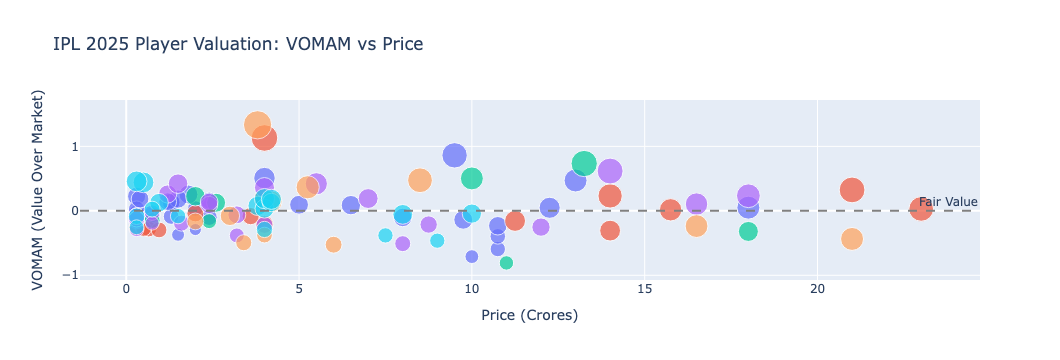

VOMAM interactive chart saved to ../results/moneyball_ipl_2025.html


In [8]:
# Handle negative WAR for size mapping (Plotly requires positive size)
# We shift WAR so the minimum is positive, then scale it
min_war = df['total_WAR'].min()
df['war_size'] = df['total_WAR'].apply(lambda x: max(0.1, x - min_war + 0.5) * 10)

fig = px.scatter(df, x='price_cr', y='vomam_score', 
                 color='role_category', size='war_size',
                 hover_name='price_name',
                 hover_data={'team': True, 'price_cr': True, 'total_WAR': ':.2f', 'vomam_score': ':.2f', 'role_category': False, 'war_size': False},
                 title='IPL 2025 Player Valuation: VOMAM vs Price',
                 labels={'price_cr': 'Price (Crores)', 'vomam_score': 'VOMAM (Value Over Market)'})

# Add a zero line for reference
fig.add_hline(y=0, line_dash="dash", line_color="gray", annotation_text="Fair Value")

# Hide the role category legend
fig.update_layout(showlegend=False)

fig.show()

# Save to HTML
output_file = PROJECT_ROOT / 'results' / 'moneyball_ipl_2025.html'
fig.write_html(str(output_file))
print(f"VOMAM interactive chart saved to {output_file}")

## 5. Conclusion

The future of auction strategy is not just buying "Good Players", but buying **"Efficient Wins"**.

**VOMAM** provides the framework for that efficiency. By understanding the premiums paid for roles and nationalities, teams can find arbitrage opportunities in the market—picking up undervalued assets that drive championship success.